# Analysis and Prediction of Bike Sharing

The dataset was obtained from the UCI Machine Learning Repository at https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset and originally published by Fanaee-T, and Gama (2013).

The research question is: how accurately can we predict the count of total rental bikes from a dataset consisting of

- instant: record index
- dteday : date
- season : season (1:springer, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit :
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt (TARGET): count of total rental bikes including both casual and registered



In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.learning_curve import learning_curve
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
%matplotlib inline

/home/patrick/programs/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
# read in data
df = pd.read_csv('hour.csv',index_col=0)

In [5]:
df.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0,3,13,16
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0,8,32,40
3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0,5,27,32
4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0,3,10,13
5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0,0,1,1


In [6]:
df.tail()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,,
17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61
17379,2012-12-31,1,1,12,23,0,1,1,1,0.26,0.2727,0.65,0.1343,12,37,49


## Exploratory Data Analysis
### The Target Variable: cnt
Lets first look at the target variable.

In [7]:
df['cnt'].describe()

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

In [8]:
np.median(df.cnt)

142.0

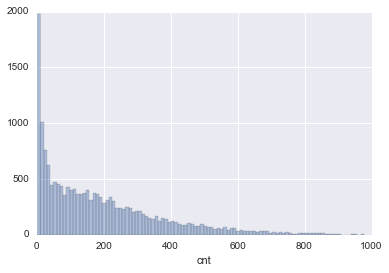

In [9]:
sns.distplot(df.cnt, bins=100, kde=None)

/home/patrick/programs/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


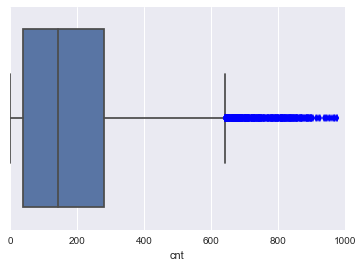

In [10]:
sns.boxplot(df.cnt)

Analysis of distribution of target variable: 
- mean: 189.46
- median: 142.0
- unimodal when using binsize of 976/100
- many outliers to the right

Many values of cnt lie between 1 and 97.6. Also, there are many outliers. In order to make better predictions it might be better if we looked at log(cnt) or sqrt(cnt).

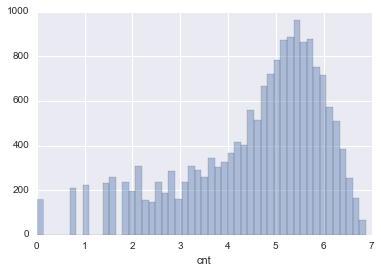

In [11]:
sns.distplot(np.log(df.cnt), bins=50, kde=None)

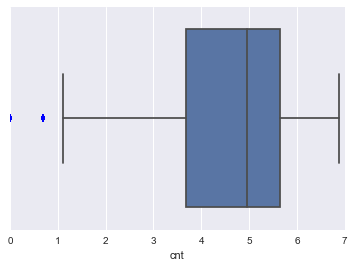

In [12]:
sns.boxplot(np.log(df.cnt))

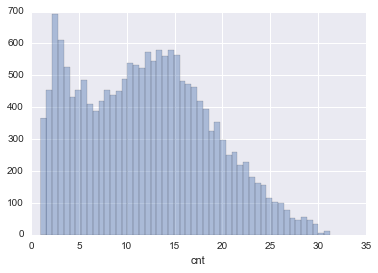

In [13]:
sns.distplot(np.sqrt(df.cnt), bins=50, kde=None)

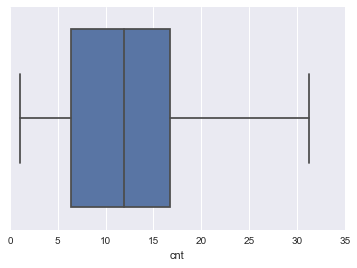

In [14]:
sns.boxplot(np.sqrt(df.cnt))

Both log(cnt) and sqrt(cnt) look to be better predictable than cnt. We add 2 more columns to the dataframe with 
log(cnt) and sqrt(cnt), respectively. 

In [15]:
df['log_cnt'] = np.log(df.cnt)

In [16]:
df['sqrt_cnt'] = np.sqrt(df.cnt)

In [17]:
df.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,log_cnt,sqrt_cnt
instant,,,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0,3,13,16,2.772589,4.000000
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0,8,32,40,3.688879,6.324555
3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0,5,27,32,3.465736,5.656854
4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0,3,10,13,2.564949,3.605551
5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0,0,1,1,0.000000,1.000000


## The Features
Looking at the available features, almost every feature could be correlated with the number of total bikes rented. 
The features can be subdivided into categorial features (season, holiday, weekday, workingday, weathersit, yr, mnth, hr)
and numerical features (temp, atemp, hum, windspeed ). Let's look at each in turn. We will plot cnt, log(cnt) and 
sqrt(cnt) to compare them. (Hint: this is just a quick exploratory data analysis. That's why the plots have no fancy labels/titels/legends.)

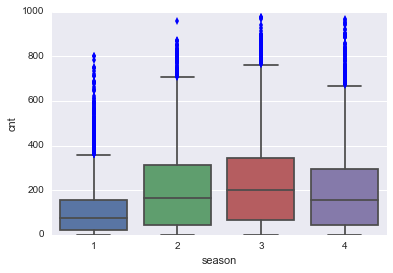

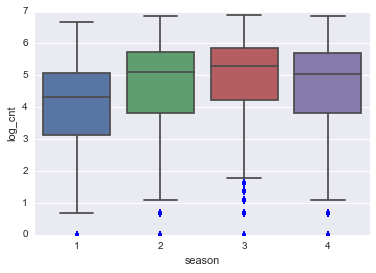

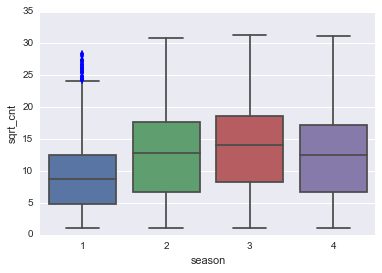

In [18]:
sns.boxplot(x=df.season, y=df.cnt)
plt.show()
sns.boxplot(x=df.season, y=df.log_cnt)
plt.show()
sns.boxplot(x=df.season, y=df.sqrt_cnt)

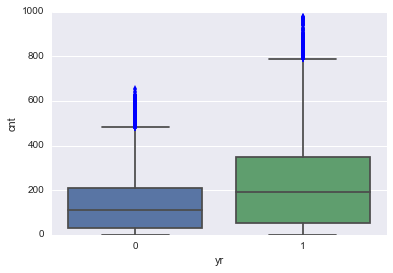

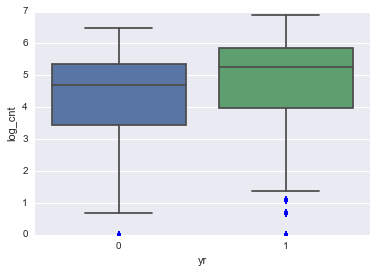

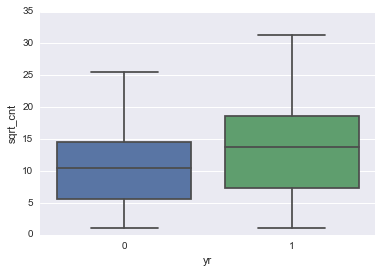

In [19]:
sns.boxplot(x=df.yr, y=df.cnt)
plt.show()
sns.boxplot(x=df.yr, y=df.log_cnt)
plt.show()
sns.boxplot(x=df.yr, y=df.sqrt_cnt)

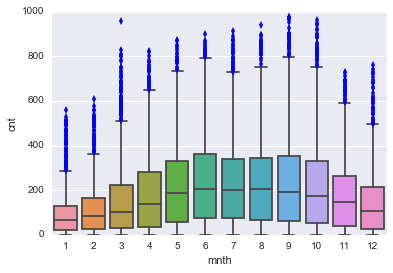

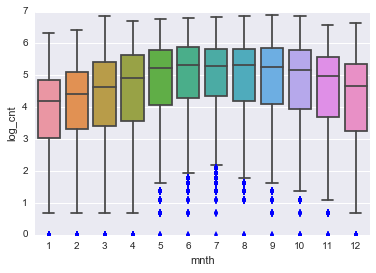

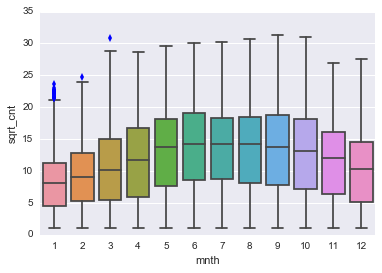

In [20]:
sns.boxplot(x=df.mnth, y=df.cnt)
plt.show()
sns.boxplot(x=df.mnth, y=df.log_cnt)
plt.show()
sns.boxplot(x=df.mnth, y=df.sqrt_cnt)

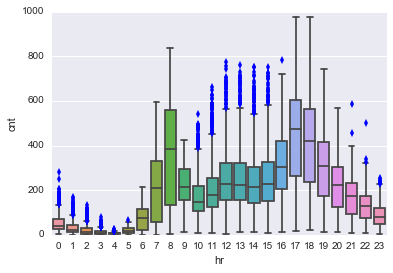

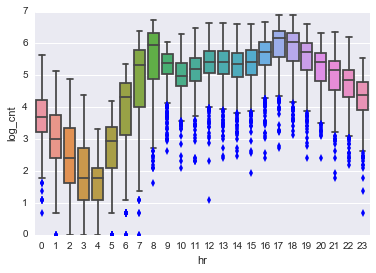

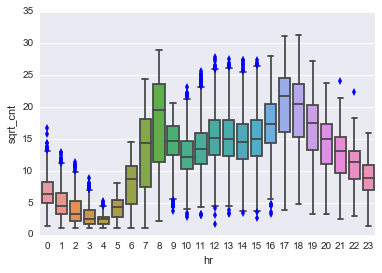

In [21]:
sns.boxplot(x=df.hr, y=df.cnt)
plt.show()
sns.boxplot(x=df.hr, y=df.log_cnt)
plt.show()
sns.boxplot(x=df.hr, y=df.sqrt_cnt)

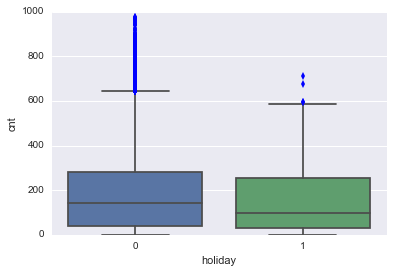

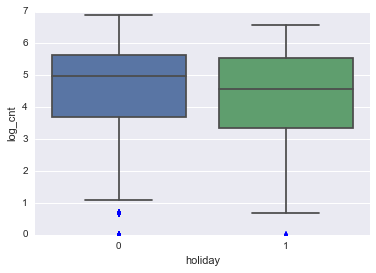

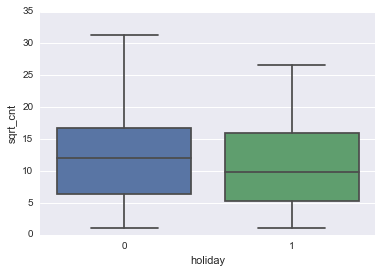

In [22]:
sns.boxplot(x=df.holiday, y=df.cnt)
plt.show()
sns.boxplot(x=df.holiday, y=df.log_cnt)
plt.show()
sns.boxplot(x=df.holiday, y=df.sqrt_cnt)

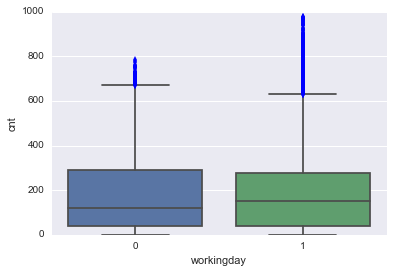

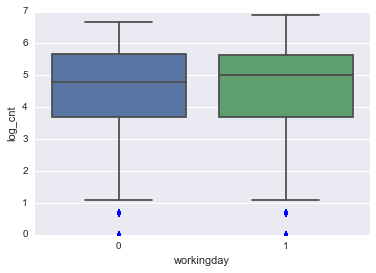

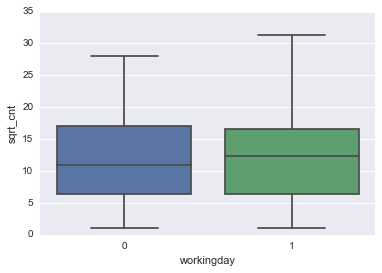

In [23]:
sns.boxplot(x=df.workingday, y=df.cnt)
plt.show()
sns.boxplot(x=df.workingday, y=df.log_cnt)
plt.show()
sns.boxplot(x=df.workingday, y=df.sqrt_cnt)

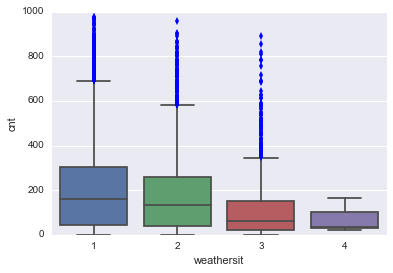

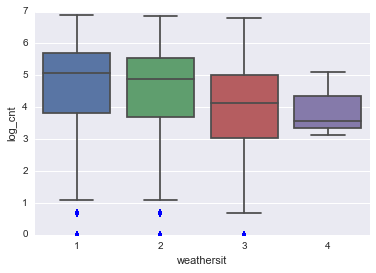

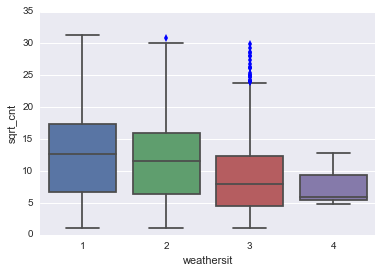

In [24]:
sns.boxplot(x=df.weathersit, y=df.cnt)
plt.show()
sns.boxplot(x=df.weathersit, y=df.log_cnt)
plt.show()
sns.boxplot(x=df.weathersit, y=df.sqrt_cnt)

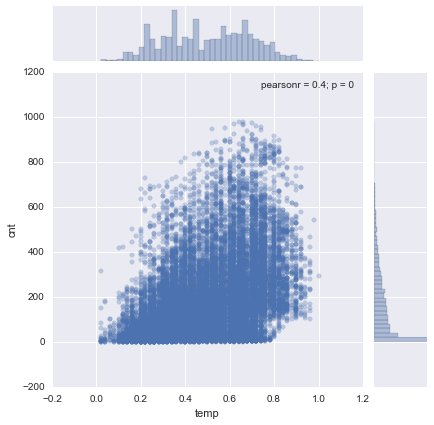

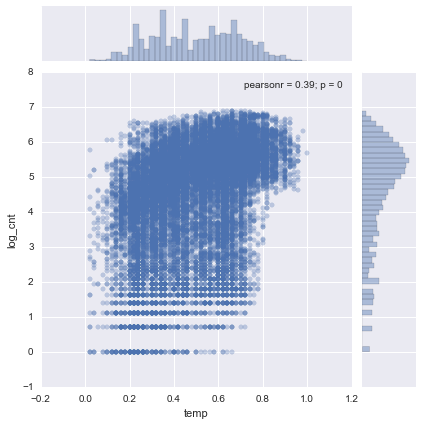

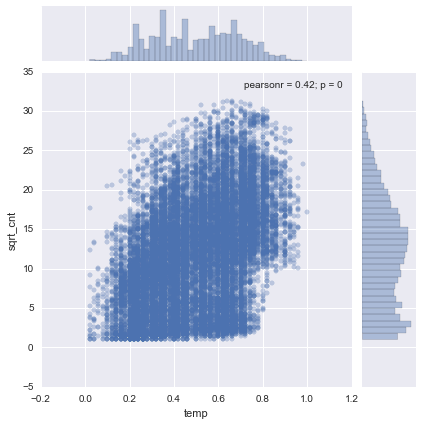

In [25]:
sns.jointplot(x=df.temp, y=df.cnt, joint_kws={'alpha':0.3})
plt.show()
sns.jointplot(x=df.temp, y=df.log_cnt, joint_kws={'alpha':0.3})
plt.show()
sns.jointplot(x=df.temp, y=df.sqrt_cnt, joint_kws={'alpha':0.3})

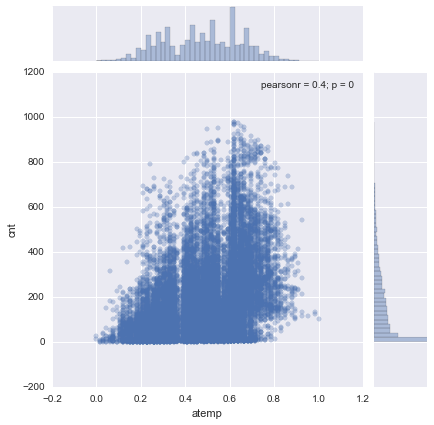

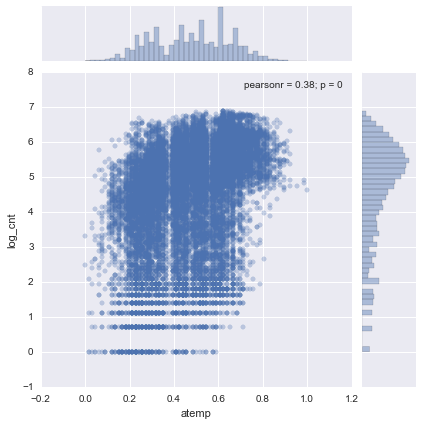

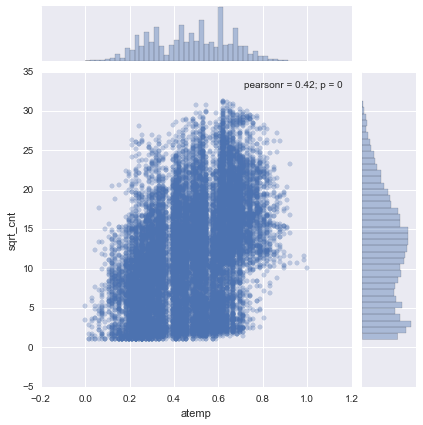

In [26]:
sns.jointplot(x=df.atemp, y=df.cnt, joint_kws={'alpha':0.3})
plt.show()
sns.jointplot(x=df.atemp, y=df.log_cnt, joint_kws={'alpha':0.3})
plt.show()
sns.jointplot(x=df.atemp, y=df.sqrt_cnt, joint_kws={'alpha':0.3})

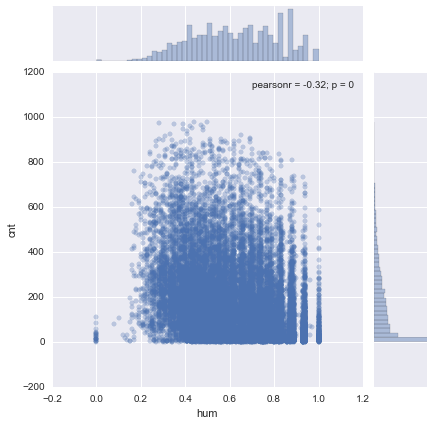

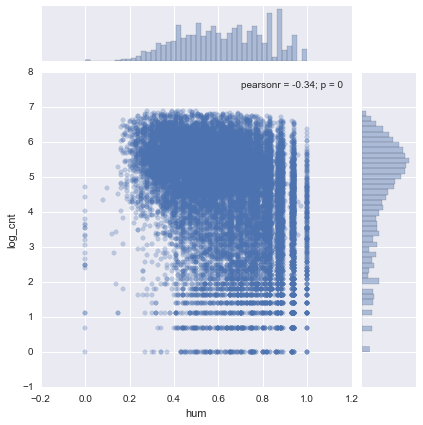

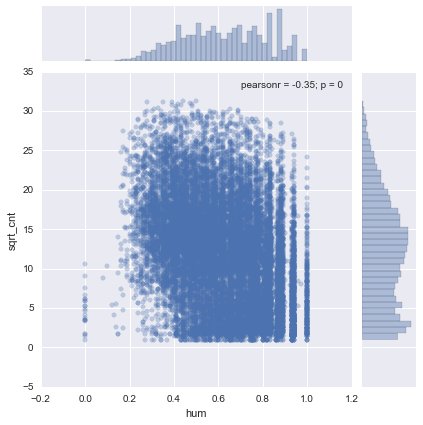

In [27]:
sns.jointplot(x=df.hum, y=df.cnt, joint_kws={'alpha':0.3})
plt.show()
sns.jointplot(x=df.hum, y=df.log_cnt, joint_kws={'alpha':0.3})
plt.show()
sns.jointplot(x=df.hum, y=df.sqrt_cnt, joint_kws={'alpha':0.3})

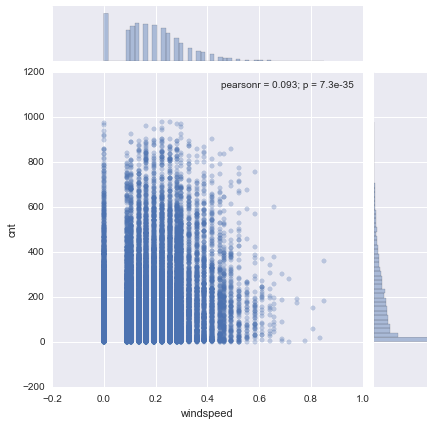

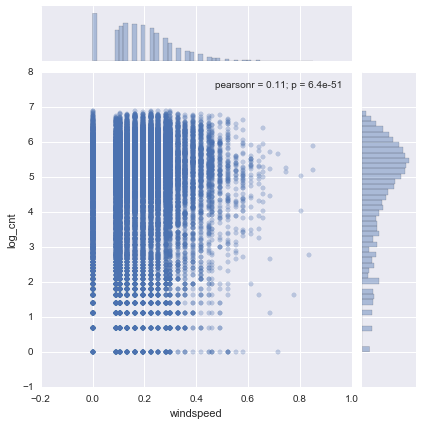

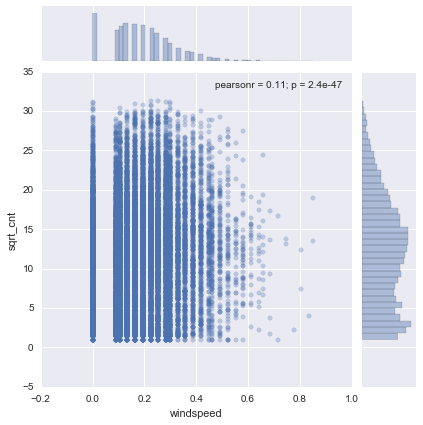

In [28]:
sns.jointplot(x=df.windspeed, y=df.cnt, joint_kws={'alpha':0.3})
plt.show()
sns.jointplot(x=df.windspeed, y=df.log_cnt, joint_kws={'alpha':0.3})
plt.show()
sns.jointplot(x=df.windspeed, y=df.sqrt_cnt, joint_kws={'alpha':0.3})

The transformation with sqrt looks better. It tends to produce less outliers than either cnt or log(cnt) and yields slightly higher correlation coefficients with the numerical features. Accordingly, it will be used henceforth.

### Check for Multicollinearity in Numerical Features
First, a visual check:

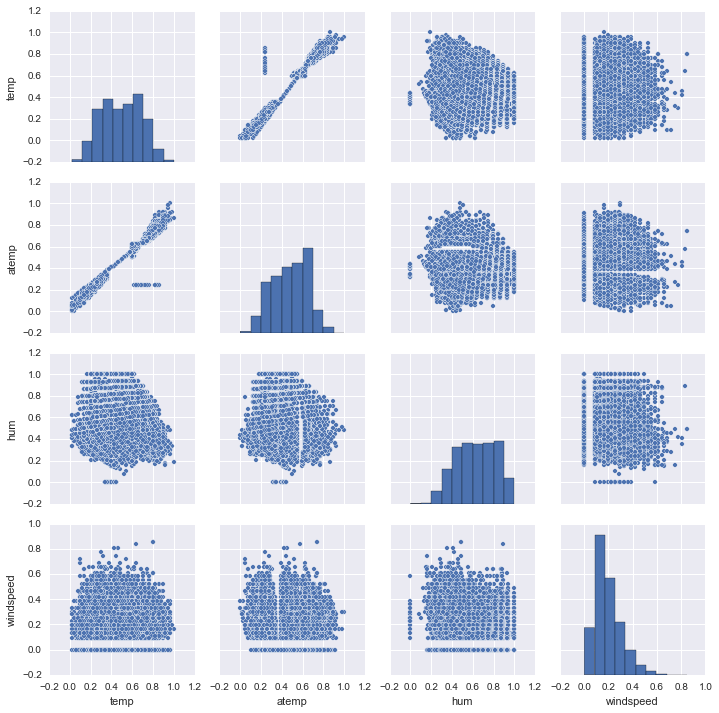

In [29]:
sns.pairplot(df[['temp', 'atemp', 'hum', 'windspeed']])

Then, a more quantitative check:

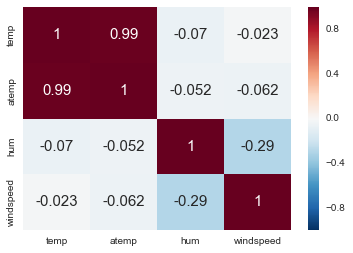

In [30]:
feature_names = ['temp', 'atemp', 'hum', 'windspeed']
cm = np.corrcoef(df[feature_names].values.T)
sns.heatmap(cm, annot=True, annot_kws={'size':15}, xticklabels=feature_names, yticklabels=feature_names)

The variables temp and atemp are clearly correlated. We will remove temp from our predictions as to not have a problem with multicollinearity. The variables hum and windspeed are weakly correlated, the rest of the numerical variables are fairly independent.

## Prediction
### Preparation of the Dataset
Before we will fit a model to the dataset, let us prepare it first.
#### Remove Unneeded Features

Remove dteday, temp, casual, registered from the dataframe. 

- The exact date in dteday cannot give us more information than the other features, in which the weather and the 
kind of day (working day, holiday,..) are given.
- Temp is strongly correlated with atemp.
- The features casual and registered are not needed for our predictions 

and since we will use sqrt(cnt) as target, cnt and log_cnt will also be unnecessary

In [31]:
# make a copy of original dataframe
df_orig = df.copy()

In [32]:
df = df.drop(['dteday', 'temp', 'casual', 'registered'],axis=1)

In [33]:
df.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,atemp,hum,windspeed,cnt,log_cnt,sqrt_cnt
instant,,,,,,,,,,,,,,
1,1,0,1,0,0,6,0,1,0.2879,0.81,0,16,2.772589,4.000000
2,1,0,1,1,0,6,0,1,0.2727,0.80,0,40,3.688879,6.324555
3,1,0,1,2,0,6,0,1,0.2727,0.80,0,32,3.465736,5.656854
4,1,0,1,3,0,6,0,1,0.2879,0.75,0,13,2.564949,3.605551
5,1,0,1,4,0,6,0,1,0.2879,0.75,0,1,0.000000,1.000000


#### One-hot Encoding of Nominal Features
We use Pandas method .get_dummies to create dummy features of the nominal variables. First, we need to check if the 
categorial data are indeed of dtype category.

In [34]:
# check dtype of data
for x in df.columns:
    print df[x].dtype

int64
int64
int64
int64
int64
int64
int64
int64
float64
float64
float64
int64
float64
float64


The categorial variables are saved as int64s. We transform them into categories:

In [35]:
# transform categorial columns to categories
for x in ['season','yr','mnth','hr','holiday','weekday','workingday','weathersit']:
    df[x] = df[x].astype('category')

In [36]:
# check if transformation succeeded
for x in df.columns:
    print df[x].dtype

category
category
category
category
category
category
category
category
float64
float64
float64
int64
float64
float64


In [37]:
# make another copy
df_with_categories = df.copy()

In [38]:
# transform categorial variables into dummy variables
df = pd.get_dummies(df)

In [39]:
df.head()

,atemp,hum,windspeed,cnt,log_cnt,sqrt_cnt,season_1,season_2,season_3,season_4,...,weekday_3,weekday_4,weekday_5,weekday_6,workingday_0,workingday_1,weathersit_1,weathersit_2,weathersit_3,weathersit_4
instant,,,,,,,,,,,,,,,,,,,,,
1,0.2879,0.81,0,16,2.772589,4.000000,1,0,0,0,...,0,0,0,1,1,0,1,0,0,0
2,0.2727,0.80,0,40,3.688879,6.324555,1,0,0,0,...,0,0,0,1,1,0,1,0,0,0
3,0.2727,0.80,0,32,3.465736,5.656854,1,0,0,0,...,0,0,0,1,1,0,1,0,0,0
4,0.2879,0.75,0,13,2.564949,3.605551,1,0,0,0,...,0,0,0,1,1,0,1,0,0,0
5,0.2879,0.75,0,1,0.000000,1.000000,1,0,0,0,...,0,0,0,1,1,0,1,0,0,0


### Choosing the Target and Creating y and X.
We said that we wanted to use sqrt(cnt) as variable because of its better properties. Let us now extract X and y from 
the dataframe and use sqrt_cnt as y.

In [40]:
## get target variable sqrt_cnt as numpy array
y = df.loc[:,['sqrt_cnt']].values

In [41]:
# get feature vectors as numpy array without the columns sqrt_cnt, log_cnt and cnt
X = df.drop(['cnt','log_cnt','sqrt_cnt',],axis=1).values

### Splitting up the Data
We are now ready to separate the data into a training and a test set. The problem states to use 10% of the data as test set.

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [43]:
# check shapes of arrays
print X_train.shape
print y_train.shape
print X_test.shape
print y_test.shape

(15641, 60)
(15641, 1)
(1738, 60)
(1738, 1)


## Machine Learning
Since the goal of the test is not a best prediction, I will will following the rough guide on 
http://scikit-learn.org/stable/tutorial/machine_learning_map/ to choose the estimator to use for this problem which 
turns out to be Ridge Regression or SVR. I use Ridge Regression because of its better computational costs.

I use 10-fold cross-validation to tune the hyperparameters of the Ridge Regression. Because I want to repeat the process
with different transformations of the target later, I will write a function to do the ridge regression and to plot
a residual plot and a plot of the learning curves to determine the bias-variance relationship.


In [44]:
def do_rigde_regression(X_train, X_test, y_train, y_test):
    """ function to do a grid search on the best parameters of a ridge regression. After having determined the 
    best parameter, use this parameter to fit a ridge regression model and make a prediction on the test data. 
    Make a residual plot to visualize the accuracy of the prediction. 
    """
    
    # Choose estimator.
    clf = Ridge()
    
    # Choose parameters to use in grid search.
    param_grid = [
        {'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
    ]
    
    # Determine parameters of grid search and fit the model. Print results to stdIO.
    gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='mean_absolute_error', cv=10, n_jobs=-1)
    res = gs.fit(X_train, y_train)
    print "The minimal mean absolute error achieved on the training set is ", res.best_score_, ". It was achieved with:", res.best_params_
    print '\n'
    
    # Fit a ridge regression model with the best parameters from the grid search and predict y_test.
    pred_clf = Ridge(alpha=res.best_params_['alpha'])
    pred_clf.fit(X_train, y_train.ravel())
    pred =pred_clf.predict(X_test)
    pred_clf.score(X_test, y_test)
    print "The prediction accuracy (R^2) on the test set is", pred_clf.score(X_test, y_test)
    
    # Determine the mean absolute error and print it to StdIO.
    print 'The mean absolute error on the test set is', mean_absolute_error(y_test, pred), '\n'
    
    # Make a residual plot.
    print '\n'
    sns.axlabel('Predictions','Residuals')
    sns.residplot(pred, pred - y_test.ravel())
    plt.show()
    
    # Plot the learning curves
    plt.clf()
    from sklearn.learning_curve import learning_curve
    train_sizes, train_scores, test_scores = learning_curve(
        pred_clf, X_train, y_train, train_sizes=np.linspace(0.1,1,10),
        cv=10, n_jobs=-1)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5,
             label='training accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, 
                    alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s',
             markersize=5, label='validation accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, 
                    alpha=0.15, color='green')
    plt.xlabel('Number of traning samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.ylim([0.65, 0.85])

The minimal mean absolute error achieved on the training set is  -2.42693697845 . It was achieved with: {'alpha': 0.001}


The prediction accuracy (R^2) on the test set is 0.781928540881
The mean absolute error on the test set is 2.49356466268 





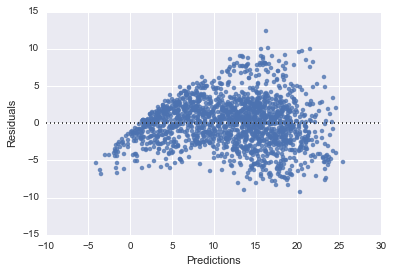

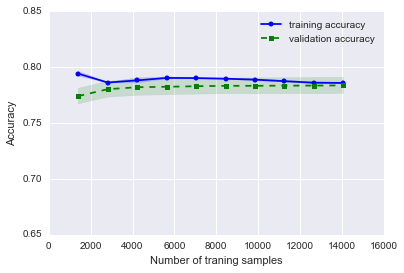

In [45]:
do_rigde_regression(X_train, X_test, y_train, y_test)

Let us now do the same with log(cnt) and cnt so see whether my intuition to use sqrt(cnt) was correct.

#### Repeat the ML with log(cnt) as Target

In [46]:
## get target variable log_cnt as numpy array
y = df.loc[:,['log_cnt']].values

In [47]:
# get feature vectors as numpy array without the columns sqrt_cnt, log_cnt and cnt
X = df.drop(['cnt','log_cnt','sqrt_cnt'],axis=1).values

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

The minimal mean absolute error achieved on the training set is  -0.463518869553 . It was achieved with: {'alpha': 0.0001}


The prediction accuracy (R^2) on the test set is 0.825672474602
The mean absolute error on the test set is 0.475988617241 





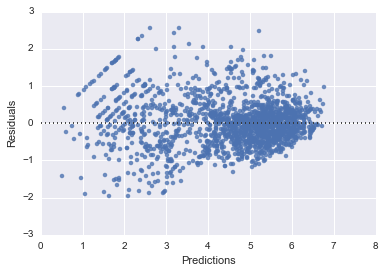

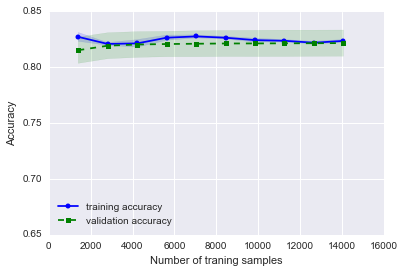

In [49]:
do_rigde_regression(X_train, X_test, y_train, y_test)

It seems my intuition was very wrong. log(cnt) yields much better results than sqrt(cnt). Let's see whether my intuition
was wrong about using any transformation.

#### Repeat the ML with cnt as Target

In [50]:
## get target variable cnt as numpy array
y = df.loc[:,['cnt']].values

In [51]:
# get feature vectors as numpy array without the columns sqrt_cnt, log_cnt and cnt
X = df.drop(['cnt','log_cnt','sqrt_cnt'],axis=1).values

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

The minimal mean absolute error achieved on the training set is  -75.2092834709 . It was achieved with: {'alpha': 10}


The prediction accuracy (R^2) on the test set is 0.680372672931
The mean absolute error on the test set is 77.4588444909 





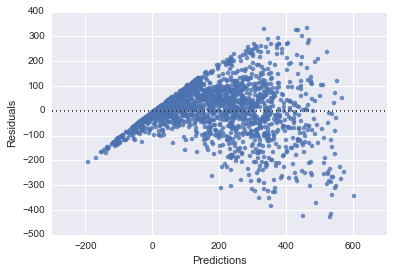

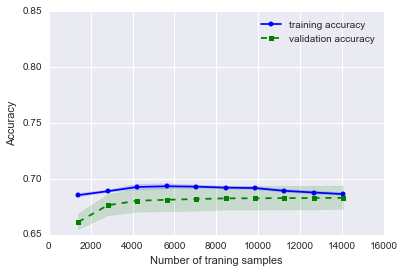

In [53]:
do_rigde_regression(X_train, X_test, y_train, y_test)

As expected, using cnt without any transformation yields a worse prediction than using either log(cnt) or sqrt(cnt). The
residual plot shows a clearly visible structure, especially for predictions above ca. 200.
The best prediction - measured by the mean absolute error and R^2 - is obtained when using log(cnt).

#### Decreasing the Bias: Using SVR
We see from the learning curve of the ridge regression model when predicting log(cnt) that the bias migth be a bit
too high. This is most likely due to the fact that we used a linear model. We now try to increase R^2 with 
a more flexible model: SVR. Due to the very high computational costs of SVR I will only do one fit and directly 
assess the accuracy of the model on the test set.

In [59]:
def do_svr(X_train, X_test, y_train, y_test):
    """ function to fit an SVR and to determine R^2 and the MAE of the predictions.
    """
    
    pred_clf = SVR(kernel='rbf', C=1000, gamma=0.1)
    pred_clf.fit(X_train, y_train.ravel())
    pred = pred_clf.predict(X_test)
    pred_clf.score(X_test, y_test)
    print "The prediction accuracy (R^2) on the test set is", pred_clf.score(X_test, y_test)
    
    # Determine the mean absolute error and print it to StdIO.
    print 'The mean absolute error on the test set is', mean_absolute_error(y_test, pred), '\n'

Predict the values for log(cnt) with SVR:

In [55]:
## get target variable log_cnt as numpy array
y = df.loc[:,['log_cnt']].values

In [56]:
# get feature vectors as numpy array without the columns sqrt_cnt, log_cnt and cnt
X = df.drop(['cnt','log_cnt','sqrt_cnt'],axis=1).values

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

Watch out! The next function will take very long to complete! I commented it out so that when running the whole
notebook, it will be skipped.

In [58]:
#do_svr(X_train, X_test, y_train, y_test)

The prediction accuracy (R^2) on the test set is 0.919036238089
The mean absolute error on the test set is 0.290226766543 



Using a more flexible method was very successful. It increased R^2 from 0.83 to 0.92 and reduced the MAE from 
0.48 to 0.29.

# Summary

#### Problem
The research question was: how accurate can we predict the count of total rental bikes from a given dataset
with categorial and numerical features.

#### Solution 
We did a quick analysis of the dataset by doing an exploratory data analysis on the target variable first and on the relationship
of the target variable to each of the features second. Then, we tried to predict the bike rentals of 10% of the original 
dataset with a ridge regression model. The ridge hyperparameter alpha was determined by grid search.

#### Result
Taking the mean absolute error and R^2 to evaluate our ridge regression model, we achieved the following results: 
- when predicting cnt without any transformation, the MAE on the test set was 77.46, R^2 was 0.68.
- when predicting sqrt(cnt), the MAE on the test set was 2.49. R^2 was 0.78.
- when predicting log(cnt), the MAE on the test set was 0.48. R^2 was 0.83.

Judging from the learning curves of ridge regression, the bias of the method was too high for our dataset. That's why
we used a SVR to repeat the fit and indeed managed to increase R^2 to 0.92 and reduced the MAE from 0.48 to 0.29.

One could try different machine learning algorithms next or try to improve the prediction accuracy by 
manual feature selection/feature engineering. But for now, I will stop here because an R^2 of 0.92 is not too bad.


## Acknowledgements
I would like to express my thanks to the UCI Machine Learning Repository [http://archive.ics.uci.edu/ml] for providing the dataset. 

## Bibliography
Fanaee-T, Hadi, and Gama, Joao, 'Event labeling combining ensemble detectors and background knowledge', Progress in Artificial Intelligence (2013): pp. 1-15, Springer Berlin Heidelberg.

Lichman, M. (2013). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science. 

Raschka, S. (2015). *Python Machine Learning*. Birmingham, UK: Packt Publishing.